In [20]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)





In [24]:
# Step 1 — Imports
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# make sure OneHotEncoder ignores unseen categories
OneHotEncoder(handle_unknown="ignore")





OneHotEncoder(handle_unknown='ignore')

In [2]:
# Step 2 — Load dataset
df = pd.read_excel('C:\\Users\\akula\\Downloads\\Raji\\Telco_customer_churn.xlsx')
df.head()


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [3]:
drop_cols = [
    'CustomerID', 'Country', 'State', 'City', 'Zip Code', 'Lat Long',
    'Latitude', 'Longitude',        # identifiers / geo info
    'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason'  # leakage
]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
df.head()


,Count,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label
0,1,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
1,1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
2,1,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
3,1,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
4,1,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes


In [4]:
df['Churn'] = LabelEncoder().fit_transform(df['Churn Label'])
df.drop(columns=['Churn Label'], inplace=True)
df[['Churn']].head()


,Churn
0,1
1,1
2,1
3,1
4,1


In [6]:
# Step 5 — Features and target
X = df.drop("Churn", axis=1)
y = df["Churn"]



In [18]:
# Step 5.1 — Collapse rare categories into "Other"
for col in X.select_dtypes(include=['object']).columns:
    freq = X[col].value_counts()
    rare = freq[freq < 10].index  # categories appearing <10 times
    X[col] = X[col].replace(rare, "Other")



In [16]:
# Replace rare categories (appearing less than 10 times) with "Other"
for col in categorical_cols:
    freq = X[col].value_counts()
    rare_cats = freq[freq < 10].index
    X[col] = X[col].replace(rare_cats, "Other")




In [7]:
# Step 6 — Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
X = df.drop(columns=['Churn'])
y = df['Churn']

X.head(), y.head()


Train shape: (5634, 20)
Test shape: (1409, 20)


(   Count  Gender Senior Citizen Partner Dependents  Tenure Months  \
 0      1    Male             No      No         No              2   
 1      1  Female             No      No        Yes              2   
 2      1  Female             No      No        Yes              8   
 3      1  Female             No     Yes        Yes             28   
 4      1    Male             No      No        Yes             49   
 
   Phone Service Multiple Lines Internet Service Online Security Online Backup  \
 0           Yes             No              DSL             Yes           Yes   
 1           Yes             No      Fiber optic              No            No   
 2           Yes            Yes      Fiber optic              No            No   
 3           Yes            Yes      Fiber optic              No            No   
 4           Yes            Yes      Fiber optic              No           Yes   
 
   Device Protection Tech Support Streaming TV Streaming Movies  \
 0               

In [8]:
# Step 7 — Identify column types
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)


Numeric cols: ['Count', 'Tenure Months', 'Monthly Charges']
Categorical cols: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Total Charges']


In [9]:
# Step 7.1 — Clean categorical columns (important fix!)
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str).fillna("Unknown")
    X_test[col] = X_test[col].astype(str).fillna("Unknown")



In [10]:
ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_cols),
        ('scale', StandardScaler(), numeric_cols)
    ],
    remainder='drop'
)


In [11]:
rf_pipe = Pipeline(steps=[
    ('preprocess', ct),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])



In [21]:
log_pipe = Pipeline(steps=[
    ('preprocess', ct),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

log_pipe.fit(X_train, y_train)
y_pred_log = log_pipe.predict(X_test)

print("\n--- Logistic Regression ---")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))



--- Logistic Regression ---
Accuracy: 0.801277501774308
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1035
           1       0.64      0.57      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



In [23]:
# ---------------- Random Forest ----------------
rf_pipe = Pipeline(steps=[
    ('preprocess', ct),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

print("\n--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))






--- Random Forest ---
Accuracy: 0.7998580553584103
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.66      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



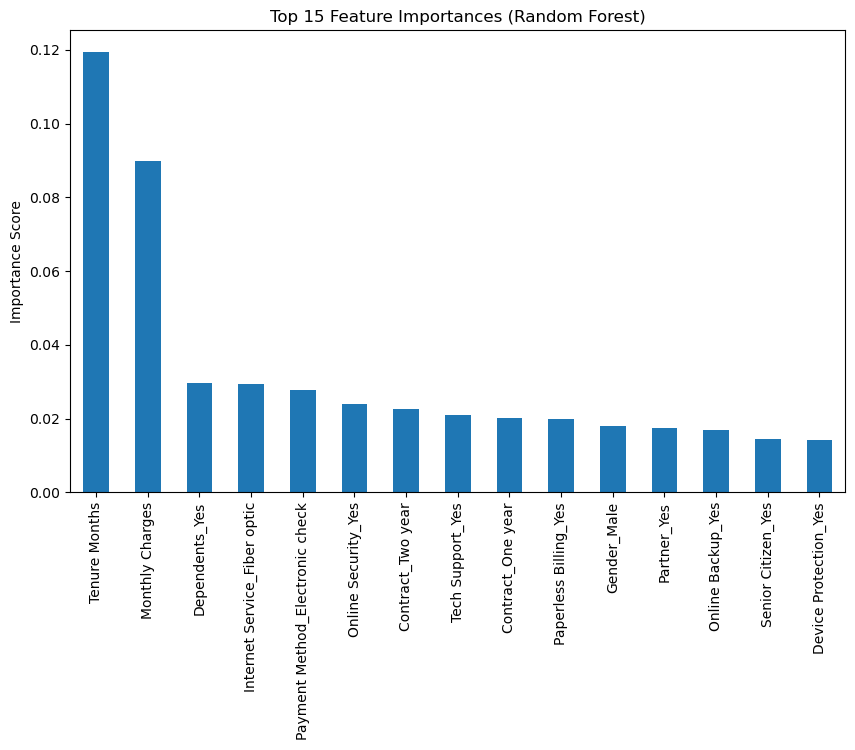

In [14]:
# Get feature names from preprocessing
onehot_features = rf_pipe.named_steps['preprocess'].transformers_[0][1].get_feature_names_out(categorical_cols)
all_features = list(onehot_features) + numeric_cols

importances = rf_pipe.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

# Plot top 15 important features
plt.figure(figsize=(10,6))
feat_imp.head(15).plot(kind='bar')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.show()


In [15]:
joblib.dump(log_pipe, "logistic_churn_model.pkl")
joblib.dump(rf_pipe, "randomforest_churn_model.pkl")

print("\nModels saved as 'logistic_churn_model.pkl' and 'randomforest_churn_model.pkl'")



Models saved as 'logistic_churn_model.pkl' and 'randomforest_churn_model.pkl'
